In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import  LayerNormalization, Conv1D, Add
import keras_tuner as kt
# Load the dataset
df = pd.read_csv('/kaggle/input/mini-project-final/T1.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [2]:
df = df[df['LV ActivePower (kW)'] >= 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50473 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50473 non-null  object 
 1   LV ActivePower (kW)            50473 non-null  float64
 2   Wind Speed (m/s)               50473 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50473 non-null  float64
 4   Wind Direction (°)             50473 non-null  float64
dtypes: float64(4), object(1)
memory usage: 2.3+ MB


In [3]:
# Step 1: Separate Date and Time using str.extract()
df[['Date', 'Time']] = df['Date/Time'].str.extract(r'(\d{2} \d{2} \d{4})\s+(\d{2}:\d{2})')
df['Date'] = pd.to_datetime(df['Date'], format='%d %m %Y')
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
df['Minute']=pd.to_datetime(df['Time'],format='%H:%M').dt.minute
# Extract additional features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month

In [4]:
df.tail()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Date,Time,Hour,Minute,Day,Month
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724,2018-12-31,23:10,23,10,31,12
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599,2018-12-31,23:20,23,20,31,12
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500,2018-12-31,23:30,23,30,31,12
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913,2018-12-31,23:40,23,40,31,12
50529,31 12 2018 23:50,2820.466064,9.979332,2779.184096,82.274620,2018-12-31,23:50,23,50,31,12


In [5]:
# Step 2: Normalize Data
scaler = MinMaxScaler()
df[['Wind Speed (m/s)', 'LV ActivePower (kW)', 'Hour', 'Day', 'Month','Theoretical_Power_Curve (KWh)','Minute']] = scaler.fit_transform(
    df[['Wind Speed (m/s)', 'LV ActivePower (kW)', 'Hour', 'Day', 'Month','Theoretical_Power_Curve (KWh)','Minute']]
)



df.iloc[10000:10010]

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Date,Time,Hour,Minute,Day,Month
10026,16 03 2018 03:00,0.324746,0.300133,0.358802,203.354004,2018-03-16,03:00,0.130435,0.0,0.5,0.181818
10027,16 03 2018 03:10,0.324350,0.296867,0.346968,205.664001,2018-03-16,03:10,0.130435,0.2,0.5,0.181818
10028,16 03 2018 03:20,0.380471,0.318885,0.431034,204.723099,2018-03-16,03:20,0.130435,0.4,0.5,0.181818
10029,16 03 2018 03:30,0.416292,0.332844,0.489001,202.124603,2018-03-16,03:30,0.130435,0.6,0.5,0.181818
10030,16 03 2018 03:40,0.498196,0.355297,0.587615,201.963303,2018-03-16,03:40,0.130435,0.8,0.5,0.181818
10031,16 03 2018 03:50,0.582137,0.374315,0.674257,202.633804,2018-03-16,03:50,0.130435,1.0,0.5,0.181818
10032,16 03 2018 04:00,0.613827,0.386628,0.728702,201.845306,2018-03-16,04:00,0.173913,0.0,0.5,0.181818
10033,16 03 2018 04:10,0.685086,0.407811,0.820523,201.372498,2018-03-16,04:10,0.173913,0.2,0.5,0.181818
10034,16 03 2018 04:20,0.706150,0.412406,0.837301,202.428696,2018-03-16,04:20,0.173913,0.4,0.5,0.181818
10035,16 03 2018 04:30,0.752914,0.417998,0.856336,202.129303,2018-03-16,04:30,0.173913,0.6,0.5,0.181818


In [ ]:
# Step 3: Prepare Sequences
def create_sequences(data, target_column_index, lookback=10, forecast_horizon=5):
    X, y = [], []
    for i in range(lookback, len(data) - forecast_horizon):  # Ensure space for 5-step prediction
        X.append(data[i-lookback:i, :])
        y.append(data[i:i+forecast_horizon, target_column_index])  # Predict next 5 values
    return np.array(X), np.array(y)

# Extract features
feature_data = df[['Theoretical_Power_Curve (KWh)', 'Wind Speed (m/s)', 'Hour', 'Day', 'Month', 'Minute', 'LV ActivePower (kW)']].values
X, y = create_sequences(feature_data, target_column_index=6, lookback=10, forecast_horizon=5)

In [6]:
def create_sequences(data, target_column_index, lookback=10):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])
        y.append(data[i, target_column_index])
    return np.array(X), np.array(y)

feature_data = df[['Theoretical_Power_Curve (KWh)','Wind Speed (m/s)', 'Hour', 'Day', 'Month','Minute', 'LV ActivePower (kW)']].values
X, y = create_sequences(feature_data, target_column_index=6)

In [14]:
# Step 3: Prepare Sequences
def create_sequences(data, target_column_index, lookback=10):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])
        y.append(data[i, target_column_index])
    return np.array(X), np.array(y)

# feature_data = df[['Theoretical_Power_Curve (KWh)','Wind Speed (m/s)', 'Hour', 'Day', 'Month', 'LV ActivePower (kW)']].values
feature_data = df[[ 'Theoretical_Power_Curve (KWh)', 'Wind Speed (m/s)', 'LV ActivePower (kW)']].values

X, y = create_sequences(feature_data, target_column_index=2)

In [7]:
# Step 4: Split into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)




In [8]:
X_train, y_train = tf.convert_to_tensor(
    X_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test, y_test = tf.convert_to_tensor(
    X_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [9]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

In [17]:
class DecompositionBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size=25):
        super(DecompositionBlock, self).__init__()
        self.conv = Conv1D(filters=1, kernel_size=kernel_size, padding='same', strides=1, use_bias=False)

    def call(self, inputs):
        trend = self.conv(inputs)
        seasonal = inputs - trend
        return seasonal, trend

# 2️⃣ Auto-Correlation Attention Mechanism (Simplified)
class AutoCorrelationAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads=8):
        super(AutoCorrelationAttention, self).__init__()
        self.num_heads = num_heads

    def call(self, inputs):
        batch_size, seq_len, dim = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2]
        
        # Fourier Transform for Frequency Domain Representation
        freq = tf.signal.fft(tf.cast(inputs, tf.complex64))
        
        # Auto-Correlation in Frequency Space
        correlation = tf.signal.ifft(freq * tf.math.conj(freq))
        
        # Take Real Part & Normalize
        output = tf.math.real(correlation) / tf.cast(seq_len, tf.float32)
        return output

# 3️⃣ Autoformer Encoder Block
def autoformer_encoder_block(inputs, num_heads=8, ff_dim=64, dropout_rate=0.1):
    # Decomposition
    seasonal, trend = DecompositionBlock()(inputs)
    
    # Auto-Correlation Attention
    attn_output = AutoCorrelationAttention(num_heads)(seasonal)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(Add()([seasonal, attn_output]))

    # Feed Forward
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    out2 = LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

    return out2 + trend  # Reconstruct Original Data

# 4️⃣ Build the Autoformer Model
def build_autoformer(seq_length, feature_dim, num_layers=4, num_heads=8, ff_dim=64, dropout_rate=0.1):
    inputs = Input(shape=(seq_length, feature_dim))
    x = inputs

    # Stack multiple encoder blocks
    for _ in range(num_layers):
        x = autoformer_encoder_block(x, num_heads, ff_dim, dropout_rate)
    
    x = Dense(64, activation='relu')(x[:, -1, :])  # Use last time step
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)  # Predict next 5 values
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

In [18]:
seq_length = 10
feature_dim = 3

In [19]:
model = build_autoformer(seq_length, feature_dim)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [ ]:
# Training the Model
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - loss: 0.0411 - mae: 0.1353 - val_loss: 0.0176 - val_mae: 0.0891
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - mae: 0.0808 - val_loss: 0.0109 - val_mae: 0.0697
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - mae: 0.0650 - val_loss: 0.0080 - val_mae: 0.0583
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0082 - mae: 0.0571 - val_loss: 0.0072 - val_mae: 0.0578
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0071 - mae: 0.0529 - val_loss: 0.0076 - val_mae: 0.0617
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - mae: 0.0516 - val_loss: 0.0061 - val_mae: 0.0514
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0064 - mae: 0.0494 - val_loss: 0.0058 - val_mae: 0.0501
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063 - mae: 0.0484 - val_loss: 0.0056 - val_mae: 0.0490
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

In [ ]:
eval_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {eval_results[0]:}, Test MAE: {eval_results[1]:}")

In [ ]:
model.save("autoformer_model_final.h5")
print("Model saved as autoformer_model.h5")

In [ ]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test.numpy(),y_pred)

print(f"R² Score: {r2:}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Conv1D, Add, Lambda
from tensorflow.keras.models import Model

class AutoCorrelationLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(AutoCorrelationLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.dense = Dense(d_model)

    def call(self, inputs):
        # Auto-Correlation (simplified)
        x = tf.signal.fft(tf.cast(inputs, tf.complex64))  # FFT Transform
        x = tf.math.real(tf.signal.ifft(x))  # Inverse FFT (correlation)
        return self.dense(x)  # Project to model dimension

# Series Decomposition Layer
class SeriesDecompositionLayer(tf.keras.layers.Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(SeriesDecompositionLayer, self).__init__(**kwargs)
        self.conv = Conv1D(filters=1, kernel_size=kernel_size, padding='same', activation='linear')

    def call(self, inputs):
        trend = self.conv(inputs)  # Trend extraction (low-pass filter)
        seasonal = inputs - trend  # Seasonal component = Original - Trend
        return seasonal, trend

# Autoformer Block (Encoder/Decoder)
def autoformer_block(inputs, d_model=64, ff_dim=128, dropout_rate=0.1):
    # Auto-Correlation Layer
    auto_corr = AutoCorrelationLayer(d_model)(inputs)
    
    # Skip Connection + Layer Normalization
    auto_corr = LayerNormalization(epsilon=1e-6)(Add()([inputs, auto_corr]))

    # Series Decomposition
    seasonal, trend = SeriesDecompositionLayer()(auto_corr)

    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation='relu')(seasonal)
    ff_output = Dense(d_model)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    
    # Final Skip Connection + Normalization
    output = LayerNormalization(epsilon=1e-6)(Add()([seasonal, ff_output]))

    return output, trend  # Return both seasonal and trend parts

# Build Autoformer Model
def build_autoformer(seq_length=10, feature_dim=7, d_model=64, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=(seq_length, feature_dim))
    x = Dense(d_model)(inputs)

    trends = []
    for _ in range(3):  # Stack 3 Autoformer Blocks
        x, trend = autoformer_block(x, d_model, ff_dim, dropout_rate)
        trends.append(trend)

    # FIXED: Sum trends using Lambda layer
    trend_output = Lambda(lambda t: tf.reduce_sum(tf.stack(t), axis=0))(trends)

    x = Dense(64, activation='relu')(x[:, -1, :])  # Use last time step
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)  # Predict next 5 steps

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

    

In [ ]:
model = build_informer()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Summary
model.summary()

In [ ]:
eval_results =model.evaluate(X_test, y_test, verbose=1)
y_pred = model.predict(X_test)
r2 = r2_score(y_test.numpy(),y_pred)
print(f"R² Score: {r2:}")
print(f"Test Loss: {eval_results[0]:.4f}, Test MAE: {eval_results[1]:.4f}")

In [ ]:
model.save("autoformer_model_10_final.h5")
print("Model saved as autoformer_model_10_final.h5")

5 iteration


In [10]:
# 1️⃣ Decomposition Block: Splits Time Series into Trend & Seasonal Components
class DecompositionBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size=25):
        super(DecompositionBlock, self).__init__()
        self.conv = Conv1D(filters=1, kernel_size=kernel_size, padding='same', strides=1, use_bias=False)

    def call(self, inputs):
        trend = self.conv(inputs)
        seasonal = inputs - trend
        return seasonal, trend

# 2️⃣ Auto-Correlation Attention Mechanism (Simplified)
class AutoCorrelationAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads=8):
        super(AutoCorrelationAttention, self).__init__()
        self.num_heads = num_heads

    def call(self, inputs):
        batch_size, seq_len, dim = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2]
        
        # Fourier Transform for Frequency Domain Representation
        freq = tf.signal.fft(tf.cast(inputs, tf.complex64))
        
        # Auto-Correlation in Frequency Space
        correlation = tf.signal.ifft(freq * tf.math.conj(freq))
        
        # Take Real Part & Normalize
        output = tf.math.real(correlation) / tf.cast(seq_len, tf.float32)
        return output

# 3️⃣ Autoformer Encoder Block
def autoformer_encoder_block(inputs, num_heads=8, ff_dim=64, dropout_rate=0.1):
    # Decomposition
    seasonal, trend = DecompositionBlock()(inputs)
    
    # Auto-Correlation Attention
    attn_output = AutoCorrelationAttention(num_heads)(seasonal)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(Add()([seasonal, attn_output]))

    # Feed Forward
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    out2 = LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

    return out2 + trend  # Reconstruct Original Data

# 4️⃣ Hyperparameter Tuning Function
def build_tuned_autoformer(hp):
    seq_length = 10
    feature_dim = 7

    inputs = Input(shape=(seq_length, feature_dim))
    x = inputs

    # Hyperparameter search space
    num_layers = hp.Int("num_layers", min_value=2, max_value=6, step=1)
    num_heads = hp.Choice("num_heads", values=[4, 8, 12])
    ff_dim = hp.Int("ff_dim", min_value=32, max_value=256, step=32)
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])

    # Stack Autoformer Encoder Blocks
    for _ in range(num_layers):
        x = autoformer_encoder_block(x, num_heads, ff_dim, dropout_rate)

    x = Dense(64, activation='relu')(x[:, -1, :])  # Use last time step
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)  # Predict next 5 time steps

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse', metrics=['mae'])

    return model

# 5️⃣ Set Up Keras Tuner
tuner = kt.BayesianOptimization(
    build_tuned_autoformer,
    objective='val_loss',
    max_trials=15,  # Number of hyperparameter combinations to test
    executions_per_trial=1,
    directory='autoformer_tuning',
    project_name='wind_forecasting'
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Watch validation loss
    patience=3,  # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Keep the best weights
    verbose=1
)
# 6️⃣ Run the Hyperparameter Search
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256, callbacks=[early_stopping])


# 7️⃣ Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: Layers={best_hps.get('num_layers')}, Heads={best_hps.get('num_heads')}, FF_Dim={best_hps.get('ff_dim')}, Dropout={best_hps.get('dropout_rate')}, LR={best_hps.get('learning_rate')}")


Trial 15 Complete [00h 00m 20s]
val_loss: 0.01939225196838379

Best val_loss So Far: 0.0049581872299313545
Total elapsed time: 00h 07m 37s
Best Hyperparameters: Layers=2, Heads=4, FF_Dim=64, Dropout=0.5, LR=0.001


In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Watch validation loss
    patience=5,  # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Keep the best weights
    verbose=1
)
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.2409 - mae: 0.3268 - val_loss: 0.0234 - val_mae: 0.1165
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0245 - mae: 0.1176 - val_loss: 0.0154 - val_mae: 0.0977
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174 - mae: 0.0989 - val_loss: 0.0126 - val_mae: 0.0919
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0143 - mae: 0.0886 - val_loss: 0.0110 - val_mae: 0.0862
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - mae: 0.0804 - val_loss: 0.0106 - val_mae: 0.0853
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - mae: 0.0735 - val_loss: 0.0094 - val_mae: 0.0796
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - mae: 0.0677 - val_loss: 0.0082 - val_mae: 0.0732
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - mae: 0.0643 - val_loss: 0.0087 - val_mae: 0.0773
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

In [12]:
eval_results = best_model.evaluate(X_test, y_test, verbose=1)
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test.numpy(),y_pred)
print(f"R² Score: {r2:}")
print(f"Test Loss: {eval_results[0]:.4f}, Test MAE: {eval_results[1]:.4f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0044 - mae: 0.0441
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
R² Score: 0.9685475802412773
Test Loss: 0.0043, Test MAE: 0.0428


1577/1577 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


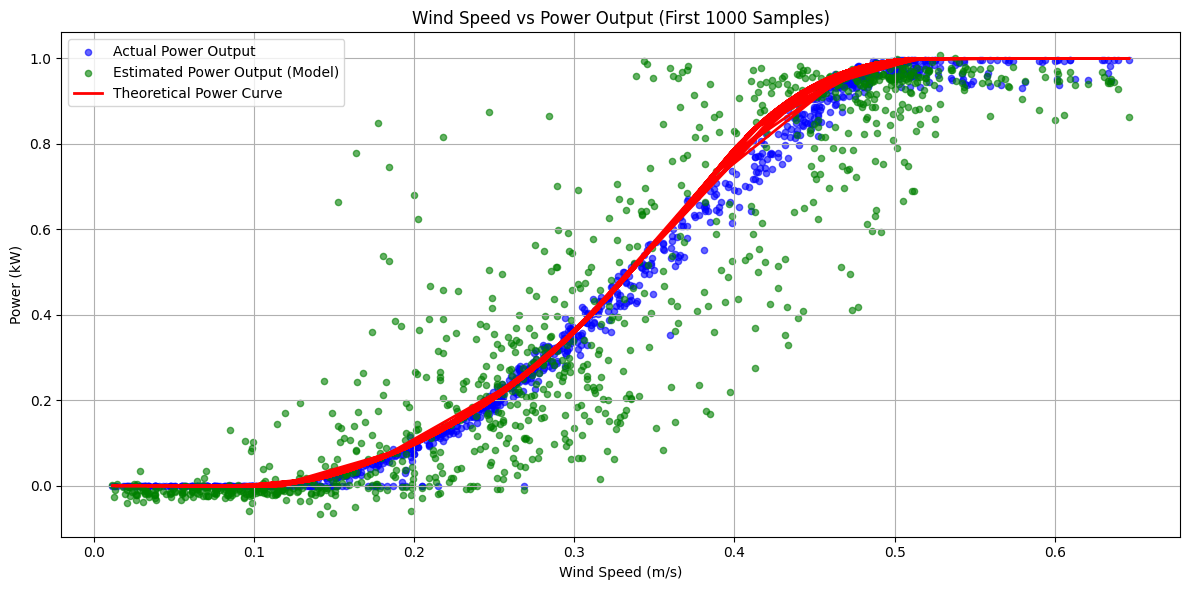

In [15]:
import matplotlib.pyplot as plt

# Step 1: Predict
y_pred = best_model.predict(X)

# Step 2: Slice first 100 values]
wind_speed = df['Wind Speed (m/s)'].values
actual_power = df['LV ActivePower (kW)'].values
theoretical_power = df['Theoretical_Power_Curve (KWh)'].values
predicted_power = y_pred.flatten()

# Step 3: Plot
plt.figure(figsize=(12, 6))

plt.scatter(wind_speed, actual_power, label='Actual Power Output', alpha=0.6, s=20, color='blue')
plt.scatter(wind_speed, predicted_power, label='Estimated Power Output (Model)', alpha=0.6, s=20, color='green')
plt.plot(wind_speed, theoretical_power, label='Theoretical Power Curve', color='red', linewidth=2)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Wind Speed vs Power Output (First 1000 Samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Conv1D, Add
from tensorflow.keras.models import Model
import numpy as np
# Informer Encoder Block
def informer_encoder_block(inputs, num_heads=8, d_model=64, ff_dim=128, dropout_rate=0.1):
    # Multi-Head Self Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(Add()([inputs, attn_output]))

    # Feed Forward Network
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(d_model)(ff_output)  # Ensure output dimension matches d_model
    ff_output = Dropout(dropout_rate)(ff_output)
    out2 = LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

    return out2

# Build Informer Model
def build_informer(seq_length=10, feature_dim=7, num_heads=8, d_model=64, ff_dim=128, dropout_rate=0.1):
    inputs = Input(shape=(seq_length, feature_dim))

    # Project input to d_model dimension
    x = Dense(d_model)(inputs)

    for _ in range(3):  # Stack 3 Informer Blocks
        x = informer_encoder_block(x, num_heads, d_model, ff_dim, dropout_rate)

    # Forecast Next 5 Steps
    x = Dense(64, activation='relu')(x[:, -1, :])  # Use last time step
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)  # Predict next 5 hours

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Example Model Training
model = build_informer()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

# Summary
model.summary()


Epoch 1/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.0311 - mae: 0.1053 - val_loss: 0.0063 - val_mae: 0.0594
Epoch 2/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0070 - mae: 0.0552 - val_loss: 0.0050 - val_mae: 0.0482
Epoch 3/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0061 - mae: 0.0506 - val_loss: 0.0060 - val_mae: 0.0526
Epoch 4/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0060 - mae: 0.0489 - val_loss: 0.0074 - val_mae: 0.0615
Epoch 5/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0061 - mae: 0.0492 - val_loss: 0.0067 - val_mae: 0.0619
Epoch 6/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0058 - mae: 0.0474 - val_loss: 0.0072 - val_mae: 0.0579
Epoch 7/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0057 - mae: 0.0469 - val_loss: 0.0058 - val_mae: 0.0508
Epoch 8/100
1262/1262 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0055 - mae: 0.0464 - val_loss: 0.0057 - val_mae: 0.0464
Epoch 9/100
1262/1262 ━━━━━━━━

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 10, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 10, 64)         │            512 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 10, 64)         │        132,672 │ dense_14[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 10, 64)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 10, 64)         │              0 │ dense_14[0][0],        │
│                           │                        │                │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 10, 64)         │            128 │ add_12[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 10, 128)        │          8,320 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 10, 64)         │          8,256 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 10, 64)         │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 10, 64)         │              0 │ layer_normalization_8… │
│                           │                        │                │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 10, 64)         │            128 │ add_13[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 10, 64)         │        132,672 │ layer_normalization_9… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 10, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 10, 64)         │              0 │ layer_normalization_9… │
│                           │                        │                │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 10, 64)         │            128 │ add_14[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,365,893 (5.21 MB)

 Trainable params: 455,297 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 910,596 (3.47 MB)

In [17]:
eval_results =model.evaluate(X_test, y_test, verbose=1)
y_pred = model.predict(X_test)
r2 = r2_score(y_test.numpy(),y_pred)
print(f"R² Score: {r2:}")
print(f"Test Loss: {eval_results[0]:.4f}, Test MAE: {eval_results[1]:.4f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0043 - mae: 0.0412
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
R² Score: 0.9698116544013061
Test Loss: 0.0042, Test MAE: 0.0378


In [18]:
model.save("informer_model_10_final.h5")
print("Model saved as autoformer_model_10_final.h5")

Model saved as autoformer_model_10_final.h5


1577/1577 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


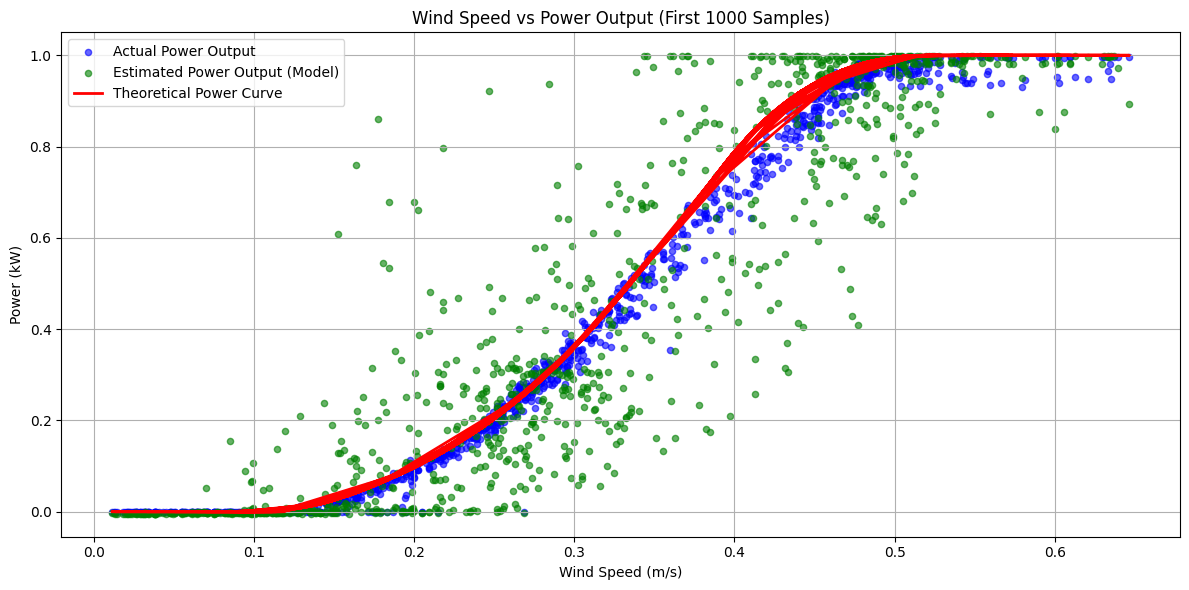

In [34]:
import matplotlib.pyplot as plt

# Step 1: Predict
y_pred = model.predict(X)

# Step 2: Slice first 100 values
n = 1000
wind_speed = df['Wind Speed (m/s)'].iloc[15:15+n].values
actual_power = df['LV ActivePower (kW)'].iloc[15:15+n].values
theoretical_power = df['Theoretical_Power_Curve (KWh)'].iloc[15:15+n].values
predicted_power = y_pred[:n].flatten()

# Step 3: Plot
plt.figure(figsize=(12, 6))

plt.scatter(wind_speed, actual_power, label='Actual Power Output', alpha=0.6, s=20, color='blue')
plt.scatter(wind_speed, predicted_power, label='Estimated Power Output (Model)', alpha=0.6, s=20, color='green')
plt.plot(wind_speed, theoretical_power, label='Theoretical Power Curve', color='red', linewidth=2)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Wind Speed vs Power Output (First 1000 Samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()